# Graph Mining
## Graph Extraction
Extract the citations graph and author -> paper graph

In [1]:
import pandas as pd
df_compdata_ref_auth = pd.read_csv('../covid-review-old/data/compdata_ref_author.csv', index_col=False)
df_compdata_ref_auth = df_compdata_ref_auth.drop(columns=['Unnamed: 0'])

In [2]:
df_compdata_ref_auth_redup = df_compdata_ref_auth.drop_duplicates(subset=['title'])
len(df_compdata_ref_auth_redup)

5686

In [3]:
df_compdata_ref_auth_redup.head(1)

,title,abstract,journal,DOI,date,collection,published,nauthors,topic.Healthcare,topic.Drug discovery,...,numcit,influcit,DL_Pdf,DL_Full,DL_Abstract,ref,authorsId,authorsNames,p_doi,p_journal
0,"Multivariate analysis of CT imaging, laborator...",PURPOSE: To develop and externally validate a ...,Abdom Radiol (NY),33098478,2020-10-25,pubmed,NaN,6,0.000988,0.000988,...,0,0,NaN,NaN,NaN,"10.5152/TJAR.2014.83436, 10.1159/000509274, 10...","4593769, 2001055410, 2001050867, 16053632, 144...","S. Hectors, Sadjad Riyahi, Hreedi Dev, K. Kris...",10.1007/s00261-020-02823-w,Abdominal Radiology


In [4]:
# Generate edge_list
import numpy as np

doi2ref = dict() # dict of doi -> reference doi's
for idx in df_compdata_ref_auth_redup.index: 
    doi2ref[df_compdata_ref_auth_redup['p_doi'].loc[idx]] = df_compdata_ref_auth_redup['ref'].loc[idx]



edge_list = list() # list of doi -> ref doi
for k in doi2ref.keys():
    if type(doi2ref[k]) is float : ## handle nan values
        continue
    
    for val in doi2ref[k].split(', '):
        if val =='NA': # ignore NA values of papers
            continue
        if val not in doi2ref.keys(): # remove edge if ref paper not in compdata
            continue
        edge_list.append((k, val))

edge_list[1]

('10.1007/s00261-020-02823-w', '10.1007/s00261-020-02671-8')

In [7]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(edge_list)

## GraphSage

In [8]:
id_map = dict()
iter_id = 0

for p_doi in df_compdata_ref_auth_redup['p_doi']:
    id_map[p_doi]  = iter_id
    iter_id = iter_id + 1

for n in G.nodes:
    if n not in id_map.keys():
        id_map[n] = iter_id
        iter_id = iter_id + 1

In [9]:
source = list()
target = list()
id_edge_list = list()
for (k,v) in edge_list:
    if k in id_map.keys() and v in id_map.keys():
        source.append(id_map[k])
        target.append(id_map[v])
        id_edge_list.append((id_map[k], id_map[v]))

pd_edge_list = pd.DataFrame(list(zip(source, target)), columns =['source', 'target'])
pd_edge_list.head(3)
#pd_edge_list.to_csv('id_edge_list.csv')

,source,target
0,0,5220
1,0,2987
2,7,3550


In [11]:
import pandas as pd
X = pd.read_csv('./data/lda_doc2vec_feats.csv', index_col=False)
y = pd.read_csv('./data/lda_doc2vec_targs.csv', index_col=False)
X = X.drop(columns=['Unnamed: 0'])
y = y.drop(columns=['Unnamed: 0'])

X = X.fillna(0)

F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Chest X-Ray', 'topic.Genomics']
node_features = X[F_LDA]
subjects = y

In [12]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
G = sg.StellarGraph(nodes={"paper": node_features}, edges={"ref": pd_edge_list}, is_directed=True)

In [14]:
pd_edge_list

,source,target
0,0,5220
1,0,2987
2,7,3550
3,7,1016
4,30,3426
...,...,...
4773,5657,1738
4774,5657,5664
4775,5673,5685
4776,5675,5684


In [15]:
print(G.info())

StellarGraph: Directed multigraph
 Nodes: 5686, Edges: 4778

 Node types:
  paper: [5686]
    Features: float32 vector, length 6
    Edge types: paper-ref->paper

 Edge types:
    paper-ref->paper: [4778]
        Weights: all 1 (default)
        Features: none


In [16]:
node_features

,topic.Healthcare,topic.Drug discovery,topic.Epidemiology,topic.Clinics,topic.Chest X-Ray,topic.Genomics
0,0.000988,0.000988,0.000988,0.443756,0.552293,0.000988
1,0.019710,0.366652,0.019710,0.554505,0.019711,0.019711
2,0.001407,0.001408,0.517966,0.476404,0.001407,0.001407
3,0.075431,0.633524,0.001084,0.029905,0.001083,0.258973
4,0.051436,0.942934,0.001407,0.001407,0.001407,0.001407
...,...,...,...,...,...,...
5681,0.001139,0.139880,0.001139,0.001139,0.001139,0.855565
5682,0.002589,0.002589,0.540791,0.002589,0.002589,0.448853
5683,0.039696,0.001344,0.001344,0.166237,0.001344,0.790035
5684,0.001528,0.087418,0.524219,0.001528,0.001528,0.383780


In [17]:
train_subjects, test_subjects = model_selection.train_test_split(
    subjects, train_size=0.1, test_size=None, stratify=subjects
)

In [18]:
train_subjects

,0
3169,True
1718,False
383,True
3276,True
5612,False
...,...
1587,False
3175,True
4439,True
5070,False


In [19]:
from collections import Counter

Counter(train_subjects)

Counter({'0': 1})

In [20]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [21]:
batch_size = 50
num_samples = [10, 5]

In [22]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [23]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [24]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [25]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [26]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [27]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [28]:
history = model.fit(
    train_gen, epochs=5, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/5
12/12 - 4s - loss: 0.0000e+00 - acc: 0.5863 - val_loss: 0.0000e+00 - val_acc: 0.5854
Epoch 2/5
12/12 - 1s - loss: 0.0000e+00 - acc: 0.5863 - val_loss: 0.0000e+00 - val_acc: 0.5854
Epoch 3/5
12/12 - 1s - loss: 0.0000e+00 - acc: 0.5863 - val_loss: 0.0000e+00 - val_acc: 0.5854
Epoch 4/5
12/12 - 1s - loss: 0.0000e+00 - acc: 0.5863 - val_loss: 0.0000e+00 - val_acc: 0.5854
Epoch 5/5
12/12 - 1s - loss: 0.0000e+00 - acc: 0.5863 - val_loss: 0.0000e+00 - val_acc: 0.5854


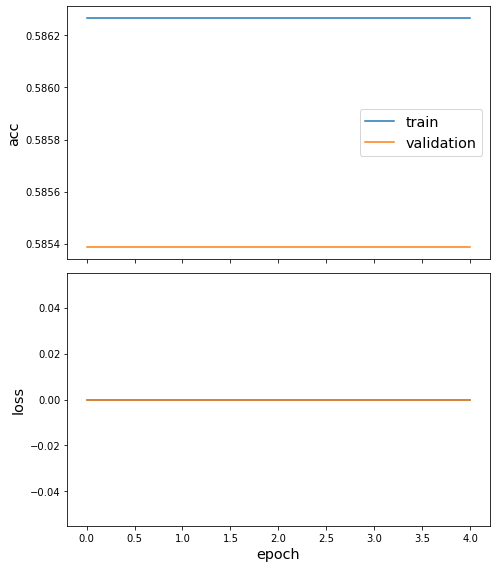

In [29]:
sg.utils.plot_history(history)

In [30]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

103/103 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - acc: 0.5854

Test Set Metrics:
	loss: 0.0000
	acc: 0.5854
